In [1]:
using Plots, Distributions, Statistics, StatsBase, StatsPlots, ProgressMeter, LsqFit, DifferentialEquations, Optim, JLD, LaTeXStrings

mutable struct Network
    Nodes::Vector{Int} # List of nodes
    States::Vector{Bool} # List of states
    Neighbors::Vector{Vector{Int}} # List of edges
    β::Float64 # Infection rate
    γ::Float64 # Recovery rate
    LAWeight::Float64 # Local Awareness Weight
    GAWeight::Float64 # Global Awareness Weight
    AEWeight::Float64 # Awareness Effect Weight
end


function BANetwork(N::Int; m::Int=2) # Barabasi-Albert Model step
    # Udirected complete graph with m nodes
    nodes = collect(1:m)
    neighbors = [[j for j ∈ nodes if j != i] for i ∈ nodes]

    for _ ∈ 1:N-m
        Samples = sample(nodes, Weights(length.(neighbors) / sum(length.(neighbors))), m, replace=true)
        push!(nodes, nodes[end] + 1)
        push!(neighbors, Samples)
        push!.(neighbors[Samples], nodes[end])
    end

    return nodes, neighbors
end

function ERNetwork(N::Int; p::Float64=0.0004) # Erdos-Renyi Model step
    nodes = collect(1:N)
    neighbors = [[j for j ∈ nodes if j != i && rand() < p] for i ∈ nodes]
    return nodes, neighbors
end

function InitializeNetwork(N::Int64, I₀::Float64, β::Float64, γ::Float64, LAWeight::Float64, GAWeight::Float64, AEWeight::Float64, NetworkConstructor::Function)
    if I₀ > 1 || I₀ < 0
        error("I₀ must be between 0 and 1")
    elseif β > 1 || β < 0
        error("β must be between 0 and 1")
    elseif γ > 1 || γ < 0
        error("γ must be between 0 and 1")
    elseif LAWeight + GAWeight != 1
        error("LAWeight + GAWeight must be 1")
    elseif LAWeight < 0 || GAWeight < 0
        error("LAWeight and GAWeight must be positive")
    elseif AEWeight > 1 || AEWeight < 0
        error("AEWeight must be between 0 and 1")
    end

    Nodes, Neighbors = NetworkConstructor(N)
    States = zeros(Int8, N)
    for node ∈ Nodes
        if rand() < I₀
            States[node] = 1
        end
    end
    return Network(Nodes, States, Neighbors, β, γ, LAWeight, GAWeight, AEWeight)
end

# SIS epidemic dynamics
function SIS!(Network::Network) # With Awareness
    for node ∈ Network.Nodes
        if Network.States[node] && rand() < Network.γ
            Network.States[node] = 0
        end
    end
    GlobalAwareness = mean(Network.States)
    for node ∈ Network.Nodes
        if !Network.States[node]
            LocalAwareness = mean(Network.States[Network.Neighbors[node]])
            TotalAwareness = Network.LAWeight * LocalAwareness + Network.GAWeight * GlobalAwareness
            AwarenessEffect = 1 - Network.AEWeight * TotalAwareness
            for neighbor ∈ Network.Neighbors[node]
                if Network.States[neighbor] && rand() < Network.β * AwarenessEffect
                    Network.States[node] = 1
                    break
                end
            end
        end
    end
end

function GetSample(N::Int64, I₀::Float64, β::Float64, γ::Float64, LAWeight::Float64, GAWeight::Float64, AEWeight::Float64, NetworkConstructor::Function; δ::Float64=0.2)
    TheNetwork = InitializeNetwork(N, I₀, β, γ, LAWeight, GAWeight, AEWeight, NetworkConstructor)
    I_Density = Float64[I₀]
    while true
        SIS!(TheNetwork)
        push!(I_Density, mean(TheNetwork.States))
        if length(I_Density) > 50 && std(I_Density[end-50:end]) < δ
            break
        end
    end
    return I_Density
end

function GetAvgTS(SampleSize::Int, NetworkConstructor::Function; N::Int64=10000, I₀::Float64=0.1, β::Float64=0.1, γ::Float64=0.15, LAWeight::Float64=0.5, GAWeight::Float64=0.5, AEWeight::Float64=0.5)
    Samples = [GetSample(N, I₀, β, γ, LAWeight, GAWeight, AEWeight, NetworkConstructor) for _ ∈ 1:SampleSize]
    ComT = minimum(length.(Samples))
    AvgI_den = [mean([Samples[i][j] for i ∈ 1:SampleSize]) for j ∈ 1:ComT]
    return AvgI_den
end

function SISODE(du, u, p, t)
    β, γ = p
    du[1] = -β * u[1] * u[2] + γ * u[2]
    du[2] = β * u[1] * u[2] - γ * u[2]
end

function cost_function(params, data)
    ode_prob = ODEProblem(SISODE, [1 - data[1], data[1]], (1, length(data)), params)
    solution = solve(ode_prob, saveat=1:length(data))
    model_data = solution[2, :]  # Assuming infected population is the second variable

    return sum((model_data - data) .^ 2)
end

function GetOptPars(params_guess::Vector{Float64}, AvgI_dens::Vector{Float64})
    result = optimize(params -> cost_function(params, AvgI_dens), params_guess, NelderMead())
    params_optimized = Optim.minimizer(result)
    return params_optimized
end

GetOptPars (generic function with 1 method)

In [2]:
# Constant Parameters
N = 10000
I₀ = 0.1
β = 0.1
γ = 0.15

# Variable Parameters
LAWeight = 0.5
GAWeight = 0.5
AEWeight = 0.5

0.5

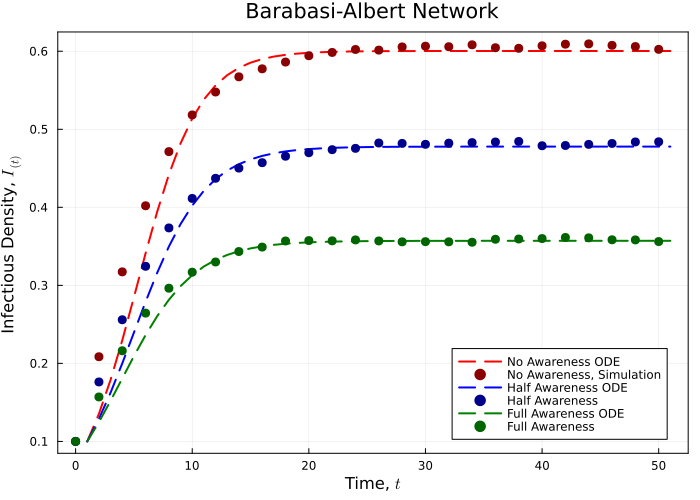

In [61]:
TheNetwork = InitializeNetwork(50000, I₀, β, γ, LAWeight, GAWeight, 0.0, BANetwork)
NoAwareness_Is = Float64[I₀]
for _ ∈ 1:50
    SIS!(TheNetwork)
    push!(NoAwareness_Is, mean(TheNetwork.States))
end

TheNetwork = InitializeNetwork(50000, I₀, β, γ, LAWeight, GAWeight, 0.5, BANetwork)
Awareness_Is = Float64[I₀]
for _ ∈ 1:50
    SIS!(TheNetwork)
    push!(Awareness_Is, mean(TheNetwork.States))
end

TheNetwork = InitializeNetwork(50000, I₀, β, γ, LAWeight, GAWeight, 1.0, BANetwork)
FullAwareness_Is = Float64[I₀]
for _ ∈ 1:50
    SIS!(TheNetwork)
    push!(FullAwareness_Is, mean(TheNetwork.States))
end

TimeSeriesData = Dict("NoAwareness" => NoAwareness_Is, "Awareness" => Awareness_Is, "FullAwareness" => FullAwareness_Is)
save("TimeSeriesData-BANetwork.jld", TimeSeriesData)
TimeSeriesData = load("TimeSeriesData-BANetwork.jld")
NoAwareness_Is = TimeSeriesData["NoAwareness"]
Awareness_Is = TimeSeriesData["Awareness"]
FullAwareness_Is = TimeSeriesData["FullAwareness"]

params_guess = [β, γ]

NA_OptPars = GetOptPars(params_guess, NoAwareness_Is)
A_OptPars = GetOptPars(params_guess, Awareness_Is)
FA_OptPars = GetOptPars(params_guess, FullAwareness_Is)

ode_prob = ODEProblem(SISODE, [1 - NoAwareness_Is[1], NoAwareness_Is[1]], (1, length(NoAwareness_Is)), NA_OptPars)
NA_Sol = solve(ode_prob, saveat=1:length(NoAwareness_Is))[2, :]

ode_prob = ODEProblem(SISODE, [1 - Awareness_Is[1], Awareness_Is[1]], (1, length(Awareness_Is)), A_OptPars)
A_Sol = solve(ode_prob, saveat=1:length(Awareness_Is))[2, :]

ode_prob = ODEProblem(SISODE, [1 - FullAwareness_Is[1], FullAwareness_Is[1]], (1, length(FullAwareness_Is)), FA_OptPars)
FA_Sol = solve(ode_prob, saveat=1:length(FullAwareness_Is))[2, :]

TimeSeriesPlot = begin
    plot(NA_Sol, label="No Awareness ODE", lw=2, lc=:red, ls=:dash)
    scatter!(0:2:50, NoAwareness_Is[1:2:end], label="No Awareness, Simulation", ms=5, msw=0, c=:darkred)
    plot!(A_Sol, label="Half Awareness ODE", lw=2, lc=:blue, ls=:dash)
    scatter!(0:2:50, Awareness_Is[1:2:end], label="Half Awareness", ms=5, msw=0, c=:darkblue)
    plot!(FA_Sol, label="Full Awareness ODE", lw=2, lc=:green, ls=:dash)
    scatter!(0:2:50, FullAwareness_Is[1:2:end], label="Full Awareness", ms=5, msw=0, c=:darkgreen)
    plot!(xlabel="Time, " * L"t", ylabel="Infectious Density, " * L"I_{(t)}", title="Barabasi-Albert Network", size=(700, 500), frame=:box)
end
savefig(TimeSeriesPlot, "TimeSeries-BANetwork.png")

display(TimeSeriesPlot)

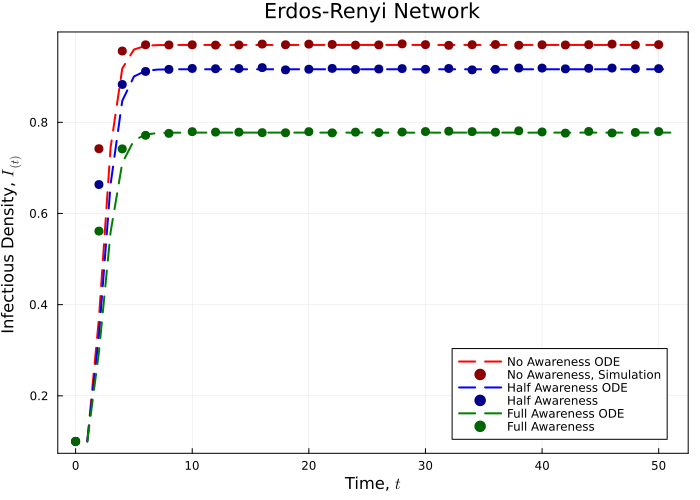

In [12]:
TheNetwork = InitializeNetwork(50000, I₀, β, γ, LAWeight, GAWeight, 0.0, ERNetwork)
NoAwareness_Is = Float64[I₀]
for _ ∈ 1:50
    SIS!(TheNetwork)
    push!(NoAwareness_Is, mean(TheNetwork.States))
end

TheNetwork = InitializeNetwork(50000, I₀, β, γ, LAWeight, GAWeight, 0.5, ERNetwork)
Awareness_Is = Float64[I₀]
for _ ∈ 1:50
    SIS!(TheNetwork)
    push!(Awareness_Is, mean(TheNetwork.States))
end

TheNetwork = InitializeNetwork(50000, I₀, β, γ, LAWeight, GAWeight, 1.0, ERNetwork)
FullAwareness_Is = Float64[I₀]
for _ ∈ 1:50
    SIS!(TheNetwork)
    push!(FullAwareness_Is, mean(TheNetwork.States))
end

TimeSeriesData = Dict("NoAwareness" => NoAwareness_Is, "Awareness" => Awareness_Is, "FullAwareness" => FullAwareness_Is)
save("TimeSeriesData-ERNetwork.jld", TimeSeriesData)
TimeSeriesData = load("TimeSeriesData-ERNetwork.jld")
NoAwareness_Is = TimeSeriesData["NoAwareness"]
Awareness_Is = TimeSeriesData["Awareness"]
FullAwareness_Is = TimeSeriesData["FullAwareness"]

params_guess = [β, γ]

NA_OptPars = GetOptPars(params_guess, NoAwareness_Is)
A_OptPars = GetOptPars(params_guess, Awareness_Is)
FA_OptPars = GetOptPars(params_guess, FullAwareness_Is)

ode_prob = ODEProblem(SISODE, [1 - NoAwareness_Is[1], NoAwareness_Is[1]], (1, length(NoAwareness_Is)), NA_OptPars)
NA_Sol = solve(ode_prob, saveat=1:length(NoAwareness_Is))[2, :]

ode_prob = ODEProblem(SISODE, [1 - Awareness_Is[1], Awareness_Is[1]], (1, length(Awareness_Is)), A_OptPars)
A_Sol = solve(ode_prob, saveat=1:length(Awareness_Is))[2, :]

ode_prob = ODEProblem(SISODE, [1 - FullAwareness_Is[1], FullAwareness_Is[1]], (1, length(FullAwareness_Is)), FA_OptPars)
FA_Sol = solve(ode_prob, saveat=1:length(FullAwareness_Is))[2, :]

TimeSeriesPlot = begin
    plot(NA_Sol, label="No Awareness ODE", lw=2, lc=:red, ls=:dash)
    scatter!(0:2:50, NoAwareness_Is[1:2:end], label="No Awareness, Simulation", ms=5, msw=0, c=:darkred)
    plot!(A_Sol, label="Half Awareness ODE", lw=2, lc=:blue, ls=:dash)
    scatter!(0:2:50, Awareness_Is[1:2:end], label="Half Awareness", ms=5, msw=0, c=:darkblue)
    plot!(FA_Sol, label="Full Awareness ODE", lw=2, lc=:green, ls=:dash)
    scatter!(0:2:50, FullAwareness_Is[1:2:end], label="Full Awareness", ms=5, msw=0, c=:darkgreen)
    plot!(xlabel="Time, " * L"t", ylabel="Infectious Density, " * L"I_{(t)}", title="Erdos-Renyi Network", size=(700, 500), frame=:box)
end
savefig(TimeSeriesPlot, "TimeSeries-ERNetwork.png")

display(TimeSeriesPlot)

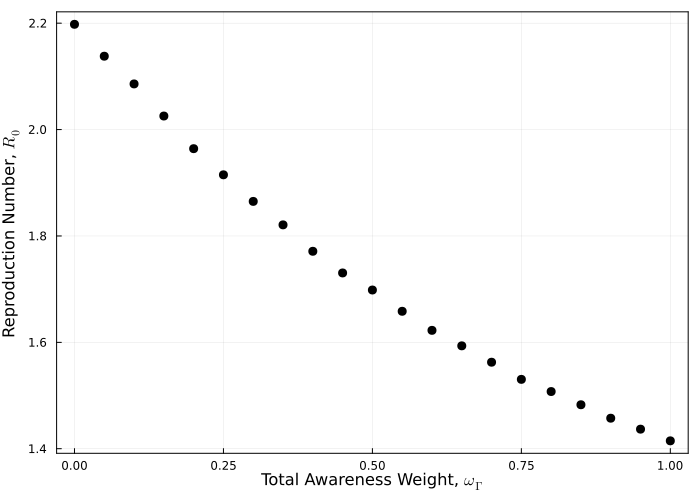

In [62]:
params_guess = [β, γ]
AEWs = 0.0:0.05:1.0
AEPars_ER = Vector[]
@showprogress for AEW ∈ AEWs
    AvgI_dens = GetAvgTS(50, ERNetwork; AEWeight=AEW)
    params_optimized = GetOptPars(params_guess, AvgI_dens)
    push!(AEPars_ER, params_optimized)
end

AwarenessEffectPlot = scatter(AEWs, first.(AEPars_ER) ./ last.(AEPars_ER), ms=5, c=:black, label=false,
    xlabel="Total Awareness Weight, "*L"\omega_\Gamma", ylabel="Reproduction Number, "*L"R_0", size=(700, 500), frame=:box)
savefig(AwarenessEffectPlot, "AE-R0-ERNetwork.png")
display(AwarenessEffectPlot)

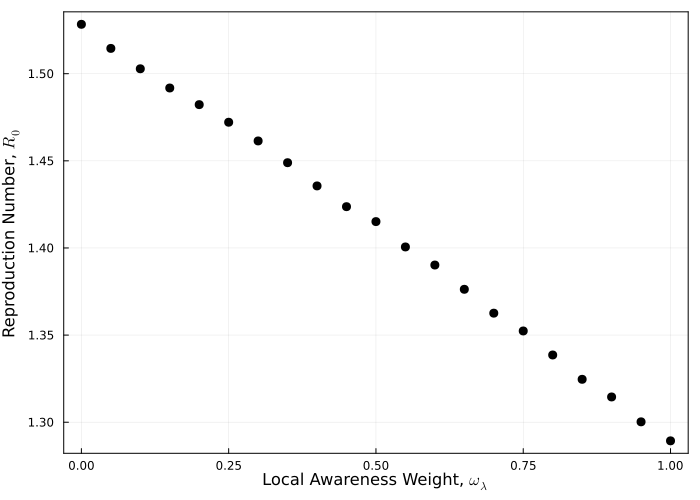

In [63]:
LAWs = 0.0:0.05:1.0
LAPars_ER = Vector[]
@showprogress for LAW ∈ LAWs
    AvgI_dens = GetAvgTS(50, ERNetwork; LAWeight=LAW, GAWeight=1 - LAW, AEWeight=1.0)
    params_optimized = GetOptPars(params_guess, AvgI_dens)
    push!(LAPars_ER, params_optimized)
end

LocalAwarenessPlot = scatter(LAWs, first.(LAPars_ER) ./ last.(LAPars_ER), ms=5, c=:black, label=false,
    xlabel="Local Awareness Weight, "*L"\omega_\lambda", ylabel="Reproduction Number, " * L"R_0", size=(700, 500), frame=:box)
savefig(LocalAwarenessPlot, "LAW-R0-ERNetwork.png")
display(LocalAwarenessPlot)

In [34]:
(LAPars_ER[end][1] / LAPars_ER[end][2]) - (LAPars_ER[1][1] / LAPars_ER[1][2])

-0.2390351425383963

In [35]:
(LAPars_BA[end][1] / LAPars_BA[end][2]) - (LAPars_BA[1][1] / LAPars_BA[1][2])

-0.36057959538880224

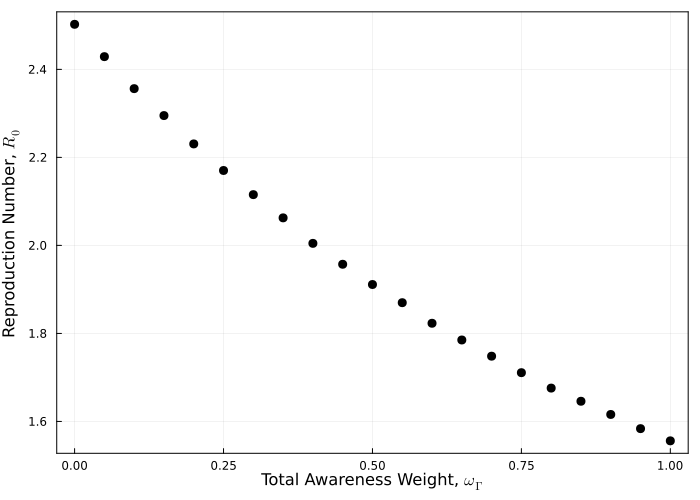

In [64]:
params_guess = [β, γ]
AEWs = 0.0:0.05:1.0
AEPars_BA = Vector[]
@showprogress for AEW ∈ AEWs
    AvgI_dens = GetAvgTS(50, BANetwork; AEWeight=AEW)
    params_optimized = GetOptPars(params_guess, AvgI_dens)
    push!(AEPars_BA, params_optimized)
end

AwarenessEffectPlot = scatter(AEWs, first.(AEPars_BA) ./ last.(AEPars_BA), ms=5, c=:black, label=false,
    xlabel="Total Awareness Weight, " * L"\omega_\Gamma", ylabel="Reproduction Number, " * L"R_0", size=(700, 500), frame=:box)
savefig(AwarenessEffectPlot, "AE-R0-BANetwork.png")
display(AwarenessEffectPlot)

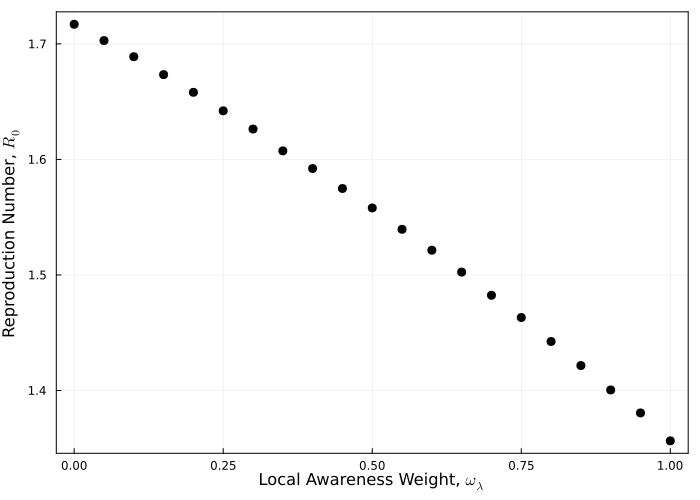

In [65]:
LAWs = 0.0:0.05:1.0
LAPars_BA = Vector[]
@showprogress for LAW ∈ LAWs
    AvgI_dens = GetAvgTS(50, BANetwork; LAWeight=LAW, GAWeight=1 - LAW, AEWeight=1.0)
    params_optimized = GetOptPars(params_guess, AvgI_dens)
    push!(LAPars, params_optimized)
end

LocalAwarenessPlot = scatter(LAWs, first.(LAPars_BA) ./ last.(LAPars_BA), ms=5, c=:black, label=false,
    xlabel="Local Awareness Weight, " * L"\omega_\lambda", ylabel="Reproduction Number, " * L"R_0", size=(700, 500), frame=:box)
savefig(LocalAwarenessPlot, "LAW-R0-BANetwork.png")
display(LocalAwarenessPlot)